***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document Main 1_1</span> 

# Vanilla Helmholtz Machine


*Updated:* Dec 11, 2024


<img src="Helmzz.jpg" style="width:550px">
<caption><center> **Figure 4**: The Helmholtz Machine  </center></caption>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [100]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

$$p_n^m(\theta, s^{m+1}) = \sigma(\sum_k \theta_{k,n}^{m+1,m} \centerdot s_k^{m+1})$$
$$q_n^m(\phi, s^{m-1}) = \sigma(\sum_k \phi_{k,n}^{m-1,m} \centerdot s_k^{m-1})$$

#### Local delta rule

$$
\begin{align}
\frac{\partial L}{\partial \theta_{j,i}}
&= (q_j - y_j)x_i \\
&=  \left \{
\begin{array}{ll}
(q_j - 1)x_i & \text{if } y_j = 1 \\
q_j \centerdot x_i & \text{if } y_j = 0
\end{array} \right.
\end{align}
$$

By gradient descent,
$$\theta = \theta - lr \centerdot \frac{\partial L}{\partial \theta}$$

In [36]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * torch.where(q != 0, torch.log(q), -100) + (1-y) * torch.where(1-q != 0, torch.log(1-q), -100)).mean()
    return loss

In [7]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = (-y.*log(q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [101]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [9]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    Grad = {}
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad["Grad_" + str(i+1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad["Grad_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Grad, Loss

In [104]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    Grad = {}
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad["Grad_" + str(i-1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Grad, Loss

In [11]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [12]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -100)).sum(axis=1,keepdims=True)
    return H

In [13]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-100)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-100))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [14]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [15]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100) + \
                    (1-p)*torch.where(1-p != 0, torch.log(1-p), -100)-(1-p)*torch.where(1-q != 0, torch.log(1-q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [16]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [17]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

### Dataset

In [18]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [19]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [20]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

### Train the Model

In [79]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [86]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [87]:
n_layer = len(n_dz)
n_layer

6

In [88]:
n_d = n_dz[0]
n_d

tensor(12)

In [89]:
well_formed_set = well_formed_generate(n_d)
well_formed_set.shape

(12, 905)

In [90]:
well_formed_set = torch.from_numpy(well_formed_set).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [91]:
entire_set = binarilize(np.arange(2**n_d),n_d,dev)
entire_set.shape

torch.Size([12, 4096])

In [92]:
Phi,Theta = para_init(n_dz)

In [93]:
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

In [94]:
Theta

{'Theta_54': tensor([[0.],
         [0.],
         [0.]], device='cuda:0'),
 'Theta_43': tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]], device='cuda:0'),
 'Theta_32': tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 'Theta_21': tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]], d

In [95]:
len(Theta)

5

In [97]:
n_data = well_formed_set.shape[1]
n_data

905

### 1. Batch Training (Wake & Sleep)

In [33]:
batch_size = n_data
data = well_formed_set
lr = 0.1
epoch = 100

In [33]:
for e in range(epoch):
    Theta, Grad_wake, Loss_wake = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Grad_sleep, Loss_sleep = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

Loss_wake: tensor([0.4398, 0.3473, 0.3540, 0.3461, 0.3421])     Loss_sleep: tensor([0.0000, 0.3508, 0.3450, 0.3493, 0.3482])
Loss_wake: tensor([0.4274, 0.3480, 0.3482, 0.3368, 0.3499])     Loss_sleep: tensor([0.0000, 0.3453, 0.3488, 0.3489, 0.3445])
Loss_wake: tensor([0.4170, 0.3393, 0.3524, 0.3492, 0.3376])     Loss_sleep: tensor([0.0000, 0.3472, 0.3496, 0.3516, 0.3448])
Loss_wake: tensor([0.4070, 0.3444, 0.3406, 0.3522, 0.3527])     Loss_sleep: tensor([0.0000, 0.3430, 0.3529, 0.3483, 0.3389])
Loss_wake: tensor([0.3981, 0.3458, 0.3471, 0.3459, 0.3417])     Loss_sleep: tensor([0.0000, 0.3361, 0.3487, 0.3366, 0.3540])
Loss_wake: tensor([0.3899, 0.3470, 0.3464, 0.3351, 0.3496])     Loss_sleep: tensor([0.0000, 0.3435, 0.3386, 0.3443, 0.3415])
Loss_wake: tensor([0.3816, 0.3534, 0.3497, 0.3471, 0.3505])     Loss_sleep: tensor([0.0000, 0.3481, 0.3517, 0.3431, 0.3442])
Loss_wake: tensor([0.3767, 0.3418, 0.3461, 0.3493, 0.3437])     Loss_sleep: tensor([0.0000, 0.3452, 0.3493, 0.3396, 0.3415])


Loss_wake: tensor([0.2910, 0.3465, 0.3474, 0.3507, 0.3381])     Loss_sleep: tensor([0.0000, 0.3308, 0.3412, 0.3328, 0.3534])
Loss_wake: tensor([0.2929, 0.3384, 0.3468, 0.3523, 0.3404])     Loss_sleep: tensor([0.0000, 0.3351, 0.3450, 0.3511, 0.3434])
Loss_wake: tensor([0.2902, 0.3480, 0.3457, 0.3531, 0.3424])     Loss_sleep: tensor([0.0000, 0.3366, 0.3373, 0.3354, 0.3558])
Loss_wake: tensor([0.2904, 0.3465, 0.3505, 0.3391, 0.3454])     Loss_sleep: tensor([0.0000, 0.3312, 0.3424, 0.3476, 0.3436])
Loss_wake: tensor([0.2890, 0.3530, 0.3386, 0.3474, 0.3537])     Loss_sleep: tensor([0.0000, 0.3358, 0.3434, 0.3490, 0.3540])
Loss_wake: tensor([0.2922, 0.3400, 0.3352, 0.3486, 0.3470])     Loss_sleep: tensor([0.0000, 0.3368, 0.3439, 0.3459, 0.3443])
Loss_wake: tensor([0.2919, 0.3422, 0.3482, 0.3464, 0.3486])     Loss_sleep: tensor([0.0000, 0.3367, 0.3499, 0.3490, 0.3521])
Loss_wake: tensor([0.2899, 0.3494, 0.3436, 0.3530, 0.3522])     Loss_sleep: tensor([0.0000, 0.3407, 0.3407, 0.3416, 0.3524])


### 2. On-line Training (Wake & Sleep)

In [102]:
batch_size = 1
data = well_formed_set
lr = 0.1
epoch = 1000

In [105]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    for i in range(n_data):
        Theta, Grad_wake, Loss_wake = wake_phase(Phi,Theta,data[:,i:i+1],lr,dev)
        Phi, Grad_sleep, Loss_sleep = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)

Loss_wake: tensor([0.4452, 0.5514, 0.6019, 0.6691, 0.6600])     Loss_sleep: tensor([0.0000, 0.5674, 0.6115, 0.6791, 0.6435])


KeyboardInterrupt: 

### 3. Wake Phase On-line; Sleep Phase Batch

In [55]:
batch_size = 100
data = well_formed_set
lr = 0.1
epoch = 100

In [56]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    for i in range(n_data):
        Theta, Grad_wake, Loss_wake = wake_phase(Phi,Theta,data[:,i:i+1],lr,dev)
        Phi, Grad_sleep, Loss_sleep = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)

Loss_wake: tensor([0.4746, 0.6378, 0.6776, 0.6904, 0.6585])     Loss_sleep: tensor([0.0000, 0.6187, 0.6498, 0.6698, 0.6451])
Loss_wake: tensor([0.4632, 0.5640, 0.5845, 0.6321, 0.5069])     Loss_sleep: tensor([0.0000, 0.5465, 0.5593, 0.6069, 0.4890])
Loss_wake: tensor([0.4388, 0.5475, 0.5050, 0.6042, 0.4659])     Loss_sleep: tensor([0.0000, 0.5230, 0.4870, 0.5660, 0.4349])
Loss_wake: tensor([0.4395, 0.5832, 0.5490, 0.5412, 0.4023])     Loss_sleep: tensor([0.0000, 0.5477, 0.5167, 0.5125, 0.3705])
Loss_wake: tensor([0.4436, 0.5172, 0.5499, 0.5703, 0.4843])     Loss_sleep: tensor([0.0000, 0.4899, 0.5150, 0.5391, 0.4171])
Loss_wake: tensor([0.4353, 0.4773, 0.5572, 0.5180, 0.3897])     Loss_sleep: tensor([0.0000, 0.4557, 0.5152, 0.5005, 0.3448])
Loss_wake: tensor([0.4304, 0.4211, 0.5289, 0.5318, 0.3332])     Loss_sleep: tensor([0.0000, 0.3925, 0.4932, 0.4783, 0.2854])
Loss_wake: tensor([0.4348, 0.4441, 0.5285, 0.5387, 0.4038])     Loss_sleep: tensor([0.0000, 0.4150, 0.4951, 0.4944, 0.3350])


Loss_wake: tensor([0.3959, 0.4423, 0.5069, 0.5909, 0.6029])     Loss_sleep: tensor([0.0000, 0.4009, 0.4487, 0.5173, 0.4720])
Loss_wake: tensor([0.3822, 0.4822, 0.4822, 0.5796, 0.6174])     Loss_sleep: tensor([0.0000, 0.4243, 0.4187, 0.5215, 0.4818])
Loss_wake: tensor([0.3709, 0.4885, 0.4744, 0.5905, 0.5836])     Loss_sleep: tensor([0.0000, 0.4290, 0.4184, 0.5263, 0.4661])
Loss_wake: tensor([0.3713, 0.4789, 0.5118, 0.5701, 0.6298])     Loss_sleep: tensor([0.0000, 0.4247, 0.4503, 0.5074, 0.4923])
Loss_wake: tensor([0.3728, 0.4819, 0.5019, 0.5696, 0.5998])     Loss_sleep: tensor([0.0000, 0.4231, 0.4555, 0.5014, 0.4638])
Loss_wake: tensor([0.3653, 0.4758, 0.4962, 0.6131, 0.5044])     Loss_sleep: tensor([0.0000, 0.4158, 0.4505, 0.5313, 0.3961])
Loss_wake: tensor([0.3731, 0.4907, 0.5025, 0.6050, 0.5270])     Loss_sleep: tensor([0.0000, 0.4199, 0.4523, 0.5319, 0.4059])
Loss_wake: tensor([0.3793, 0.4936, 0.5194, 0.6030, 0.4894])     Loss_sleep: tensor([0.0000, 0.4118, 0.4694, 0.5473, 0.3653])


In [34]:
np.save('Theta',Theta)
np.save('Phi',Phi)

In [66]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [67]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

In [68]:
sleep_ct

{'Layer 4: dist': tensor([8.2360e-03, 6.1757e-04, 8.8847e-01, 6.6621e-02, 3.0808e-04, 2.3101e-05,
         3.3234e-02, 2.4920e-03]),
 'Layer 4: H_Y': tensor(0.4604),
 'Layer 4: H_YX': tensor([0.4604]),
 'Layer 3: dist': tensor([1.7985e-03, 3.4157e-02, 4.3423e-04, 8.8537e-03, 3.1551e-04, 3.7481e-03,
         1.7063e-04, 1.1463e-03, 8.4757e-04, 1.4055e-02, 2.6404e-04, 3.6804e-03,
         2.3422e-04, 1.6455e-03, 1.5267e-04, 5.4672e-04, 9.8455e-03, 2.8143e-01,
         2.7012e-03, 8.9186e-02, 1.0521e-03, 3.0998e-02, 4.2031e-04, 1.0621e-02,
         3.7755e-03, 1.1034e-01, 1.1490e-03, 3.5850e-02, 5.0183e-04, 1.2550e-02,
         2.4750e-04, 4.3671e-03, 5.7967e-04, 1.3100e-02, 2.5643e-04, 4.3718e-03,
         1.8199e-04, 1.6104e-03, 1.4500e-04, 6.3416e-04, 3.1619e-04, 5.3029e-03,
         1.8265e-04, 1.8394e-03, 1.5453e-04, 7.2941e-04, 1.3634e-04, 3.3349e-04,
         4.4747e-03, 1.4059e-01, 1.4417e-03, 4.7117e-02, 5.8254e-04, 1.6168e-02,
         2.8183e-04, 5.7230e-03, 1.7958e-03, 5.5705e

In [69]:
wake_ct

{'Layer 0: dist': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011]),
 'Layer 1: dist': tensor([2.0508e-03, 3.6825e-04, 1.1174e-01,  ..., 2.5156e-08, 5.6181e-07,
         4.9453e-08]),
 'Layer 1: H_Y': tensor(4.3200),
 'Layer 1: H_YX': tensor([2.8874]),
 'Layer 2: dist': tensor([1.5277e-02, 4.7469e-04, 1.7152e-03, 1.1915e-04, 4.4440e-04, 4.8602e-05,
         1.1185e-04, 2.0162e-05, 3.8856e-04, 4.7693e-05, 1.4419e-04, 2.6025e-05,
         4.6030e-05, 1.4356e-05, 2.5150e-05, 1.0585e-05, 5.4295e-04, 5.9692e-05,
         1.0439e-04, 2.3851e-05, 5.1215e-05, 1.5649e-05, 1.9216e-05, 1.0289e-05,
         5.2516e-05, 1.6307e-05, 2.3511e-05, 1.1470e-05, 1.5154e-05, 9.7268e-06,
         1.0237e-05, 8.5312e-06, 1.1063e-03, 9.4520e-05, 2.1150e-04, 2.9589e-05,
         1.0199e-04, 2.0213e-05, 3.0296e-05, 1.0975e-05, 6.1780e-05, 1.6281e-05,
         2.6118e-05, 1.0935e-05, 1.7847e-05, 1.0231e-05, 1.1225e-05, 8.5759e-06,
         8.9478e-05, 1.9285e-05, 2.6235e-05, 1.1094e-05, 2.0025e-05, 

In [68]:
wake_ft['Layer 1: H_Y'] - wake_ft['Layer 1: H_YX']

tensor([0.0007])

In [60]:
wake_ft['Layer 1: dist'].to('cpu').numpy()

array([0.5274781 , 0.5509076 , 0.5202749 , 0.52567774, 0.52180445,
       0.53205156, 0.5267391 , 0.54875803, 0.531781  , 0.5266533 ],
      dtype=float32)

In [92]:
dist_w = wake_ct['Layer '+str(0)+': dist']
dist_w

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [93]:
dist_s = sleep_ct['Layer '+str(0)+': dist']
dist_s

tensor([6.1293e-06, 5.8496e-06, 8.0406e-06,  ..., 1.9051e-03, 3.5757e-03,
        3.2457e-03])

In [101]:
KL_divergence(dist_w,dist_s)

tensor(0.5924)

In [106]:
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [125]:
np.around(sleep_ct['Layer '+str(i)+': H_YX'].item(),4)

2.0793

Layer 0 Data Distribution D_KL: 26.2287
Layer 0 Generative  Distribution D_KL: 2.7536 H(Y): 5.8125 H(Y|X): 4.2151 I_XY: 1.5973
Layer 1 Recognition Distribution D_KL: 0.4209 H(Y): 4.32 H(Y|X): 2.8874 I_XY: 1.4327
Layer 1 Generative  Distribution D_KL: 0.3761 H(Y): 4.6912 H(Y|X): 4.493 I_XY: 0.1982
Layer 2 Recognition Distribution D_KL: 0.017 H(Y): 1.0884 H(Y|X): 0.8656 I_XY: 0.2228
Layer 2 Generative  Distribution D_KL: 0.0205 H(Y): 0.854 H(Y|X): 0.6761 I_XY: 0.1779
Layer 3 Recognition Distribution D_KL: 0.0252 H(Y): 2.4411 H(Y|X): 2.2295 I_XY: 0.2117
Layer 3 Generative  Distribution D_KL: 0.0242 H(Y): 2.6067 H(Y|X): 2.5359 I_XY: 0.0708
Layer 4 Recognition Distribution D_KL: 0.0044 H(Y): 0.4969 H(Y|X): 0.4047 I_XY: 0.0922
Layer 4 Generative  Distribution D_KL: 0.0078 H(Y): 0.4604 H(Y|X): 0.4604 I_XY: 0.0


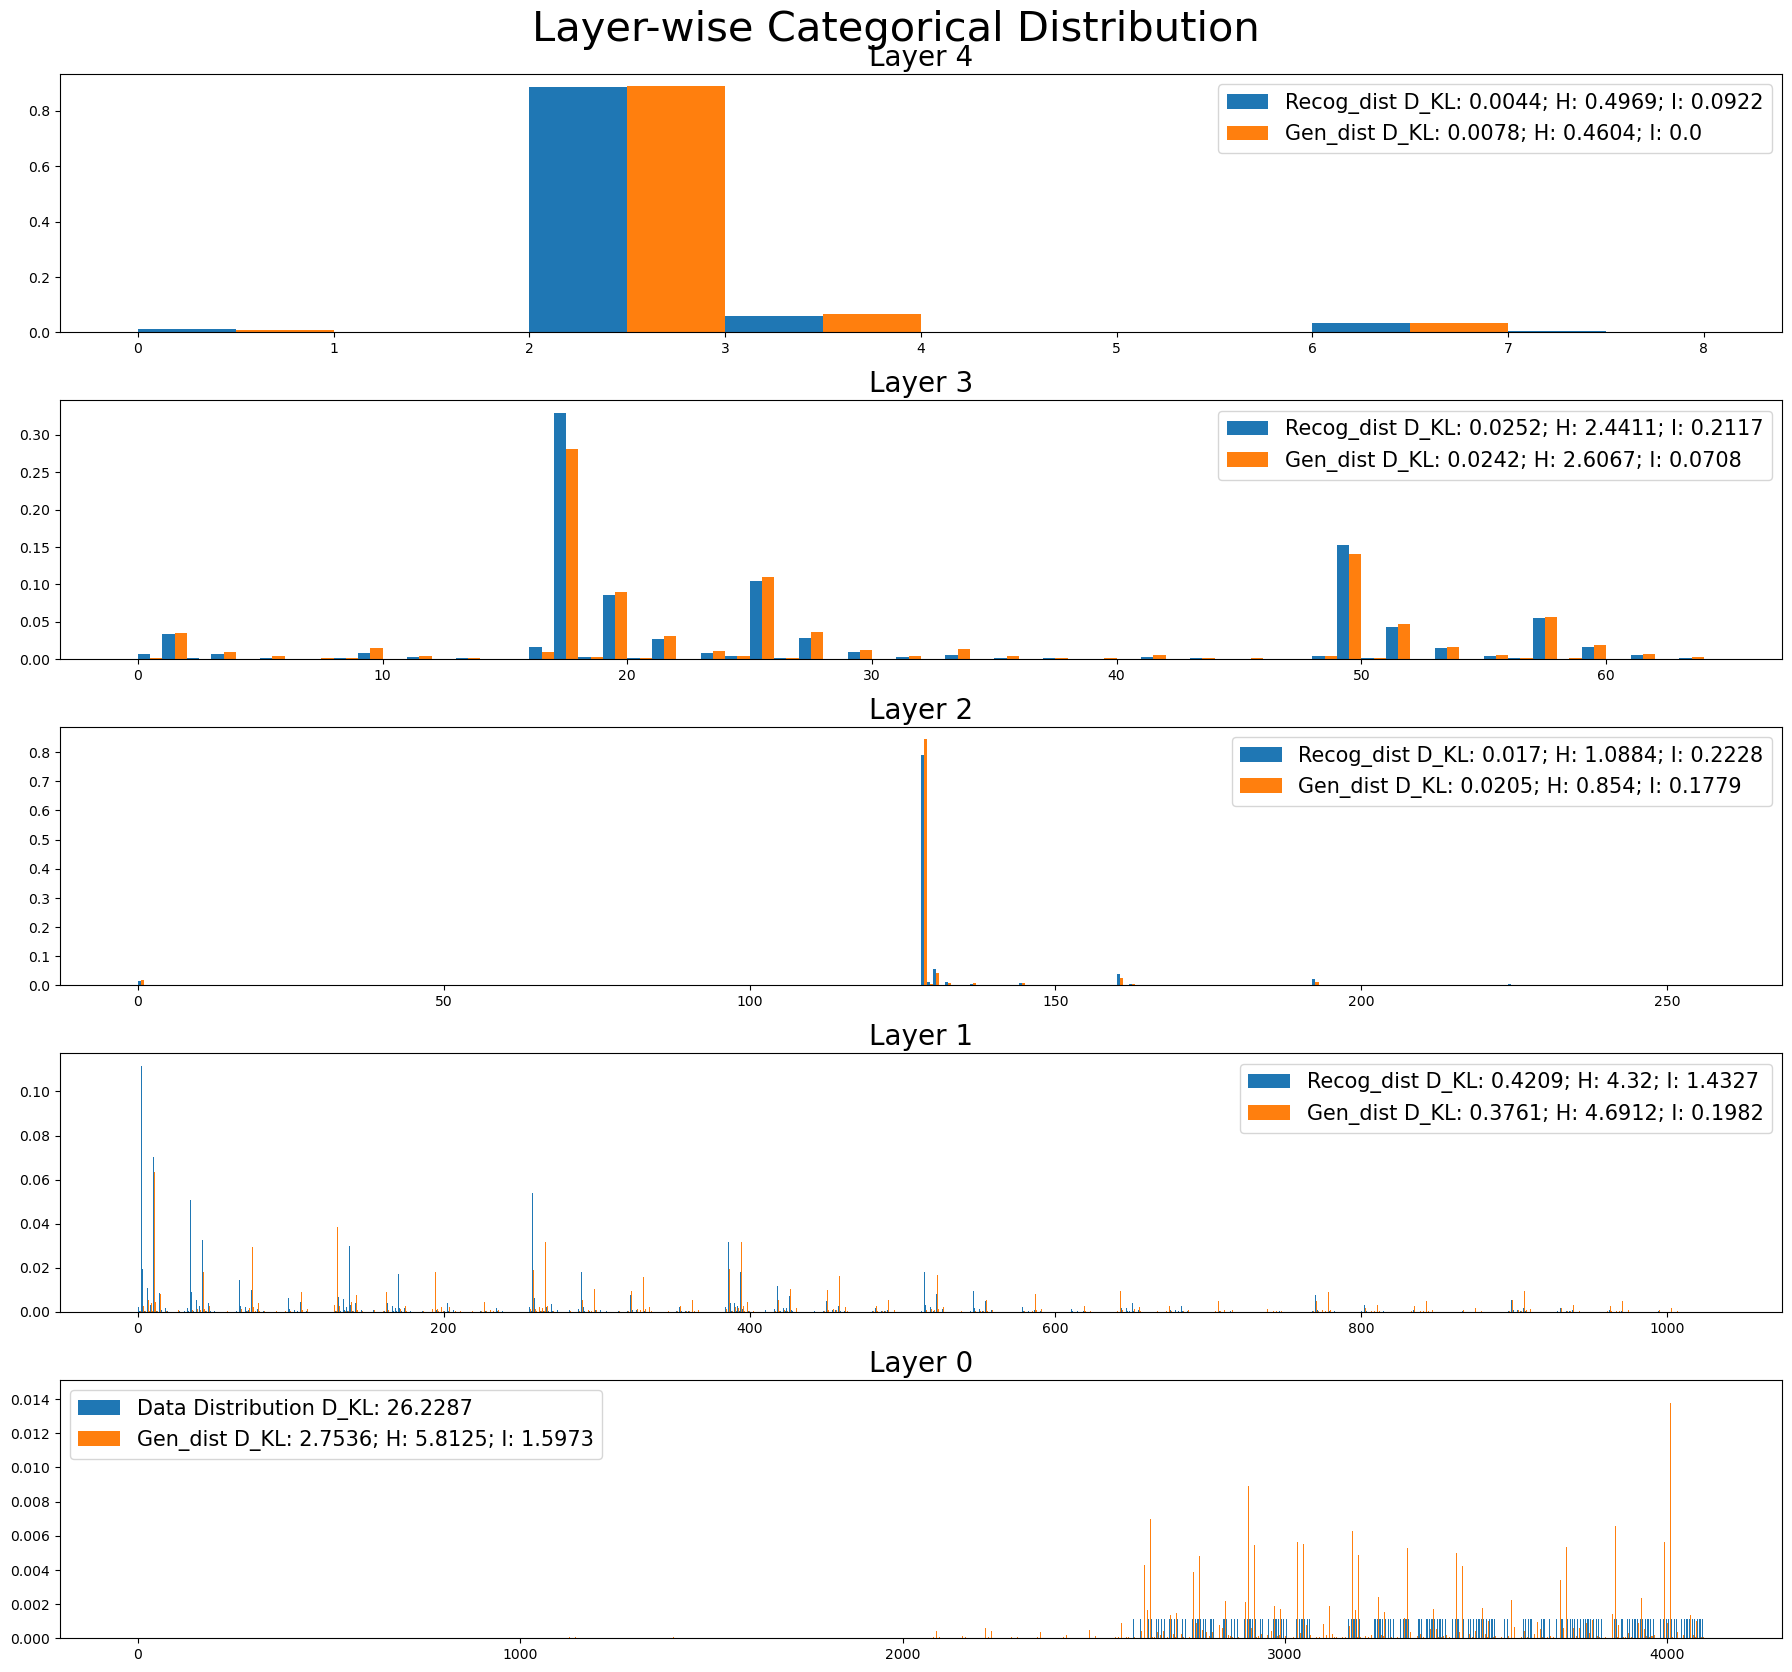

In [75]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
    H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
    H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
    I_s = H_Y_s - H_YX_s
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i == 0:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        print("Layer "+str(i), "Data Distribution D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data Distribution D_KL: " + str(np.around(D_KL_w,4)))
    else:
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
    ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
plt.tight_layout(pad=1)    
plt.show()

In [143]:
wake_ft

{'Layer 1: dist': tensor([0.5275, 0.5509, 0.5203, 0.5257, 0.5218, 0.5321, 0.5267, 0.5488, 0.5318,
         0.5267]),
 'Layer 1: H_Y': tensor(6.9100),
 'Layer 1: H_YX': tensor([6.9093]),
 'Layer 2: dist': tensor([0.4974, 0.4954, 0.5062, 0.5036, 0.4994, 0.5141, 0.4990, 0.5035]),
 'Layer 2: H_Y': tensor(5.5446),
 'Layer 2: H_YX': tensor([5.5444]),
 'Layer 3: dist': tensor([0.4958, 0.5089, 0.5044, 0.4986, 0.4984, 0.5021]),
 'Layer 3: H_Y': tensor(4.1586),
 'Layer 3: H_YX': tensor([4.1585]),
 'Layer 4: dist': tensor([0.4988, 0.5077, 0.4995]),
 'Layer 4: H_Y': tensor(2.0793),
 'Layer 4: H_YX': tensor([2.0793])}

In [144]:
sleep_ft

{'Layer 4: dist': tensor([0.4993, 0.5093, 0.4989]),
 'Layer 4: H_Y': tensor(2.0793),
 'Layer 4: H_YX': tensor([2.0793]),
 'Layer 3: dist': tensor([0.4997, 0.4998, 0.5000, 0.4990, 0.5009, 0.5007]),
 'Layer 3: H_Y': tensor(4.1589),
 'Layer 3: H_YX': tensor([4.1589]),
 'Layer 2: dist': tensor([0.4971, 0.4978, 0.5054, 0.5003, 0.4997, 0.5128, 0.4957, 0.5020]),
 'Layer 2: H_Y': tensor(5.5447),
 'Layer 2: H_YX': tensor([5.5446]),
 'Layer 1: dist': tensor([0.5304, 0.5433, 0.5185, 0.5180, 0.5167, 0.5283, 0.5171, 0.5362, 0.5241,
         0.5239]),
 'Layer 1: H_Y': tensor(6.9169),
 'Layer 1: H_YX': tensor([6.9150]),
 'Layer 0: dist': tensor([0.9448, 0.6416, 0.6787, 0.5476, 0.5665, 0.5854, 0.5991, 0.5919, 0.5936,
         0.6227, 0.6154, 0.4790]),
 'Layer 0: H_Y': tensor(7.5917),
 'Layer 0: H_YX': tensor([7.5475])}

Layer 0 Generative  Distribution D_KL: 0.0 H(Y): 7.5917 H(Y|X): 7.5475 I_XY: 0.0443
Layer 1 Recognition Distribution D_KL: 0.001 H(Y): 6.91 H(Y|X): 6.9093 I_XY: 0.0007
Layer 1 Generative  Distribution D_KL: 0.001 H(Y): 6.9169 H(Y|X): 6.915 I_XY: 0.0019
Layer 2 Recognition Distribution D_KL: 0.0001 H(Y): 5.5446 H(Y|X): 5.5444 I_XY: 0.0002
Layer 2 Generative  Distribution D_KL: 0.0001 H(Y): 5.5447 H(Y|X): 5.5446 I_XY: 0.0001
Layer 3 Recognition Distribution D_KL: 0.0002 H(Y): 4.1586 H(Y|X): 4.1585 I_XY: 0.0001
Layer 3 Generative  Distribution D_KL: 0.0002 H(Y): 4.1589 H(Y|X): 4.1589 I_XY: 0.0
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 2.0793 H(Y|X): 2.0793 I_XY: 0.0
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 2.0793 H(Y|X): 2.0793 I_XY: 0.0


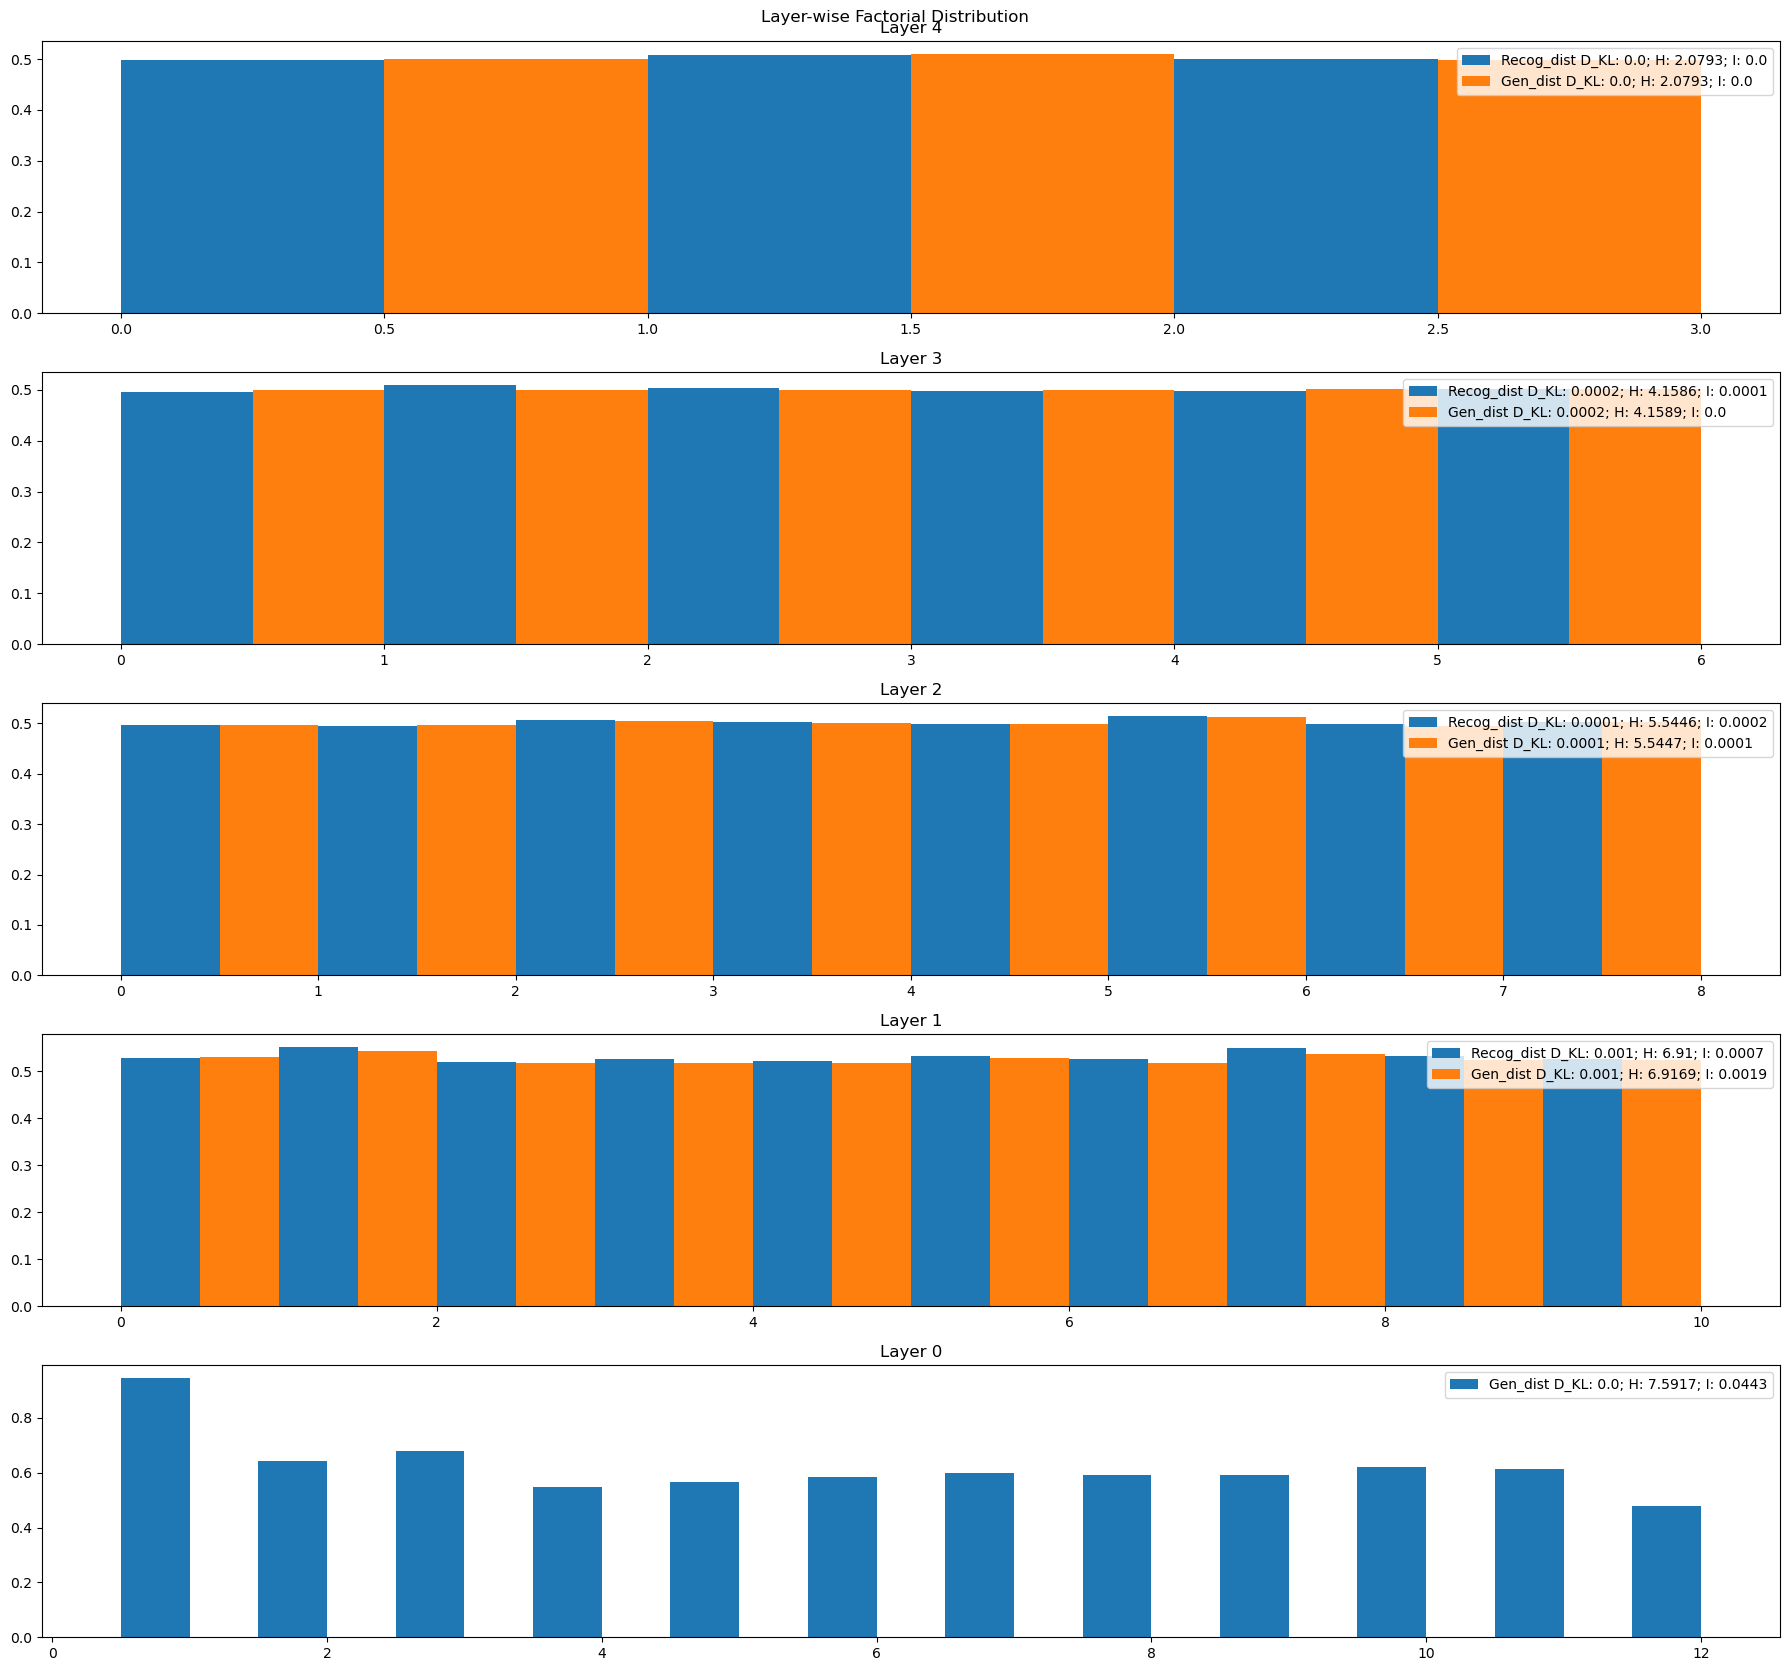

In [149]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Factorial Distribution")
D_KL_s = 0
for i in range(n_layer-1):
    dist_s = sleep_ft['Layer '+str(i)+': dist']
    if i > 0:
        dist_w = wake_ft['Layer '+str(i)+': dist']
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
        
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        
    H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
    H_YX_s = sleep_ft['Layer '+str(i)+': H_YX'].item()
    I_s = H_Y_s - H_YX_s
    
    
    ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i))
    ax_ct[n_layer-2-i].legend()
    
    print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
plt.tight_layout()    
plt.show()